# 2.10 - Image analysis, pt. 2

### Learning goals for today
1. Use a **pseudocoding** method to write analysis code
2. Learn some basics of automatic cell counting / quantification
3. Build a pipeline for data analysis

---
### How to use this notebook during class
- Follow along as we go
- Use your **Cards** to indicate where you're at:
    - A **🟩Green card** means you are caught up with Max and **ready to help your classmates**
    - A **🟥Red card** means you are stuck and need help
- <span style='color:red;'>EXERCISE</span> — work on this problem by yourself, or try with a partner if you get stuck
---


First let's import some libraries we will use today. Remember if you don't have a library installed you can pip install it with:

%pip install *package_name*

In [ ]:
%pip install scikit-image

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage
from skimage.io import imread

## 1) Automatic cell detection

Let's load our image from last time...

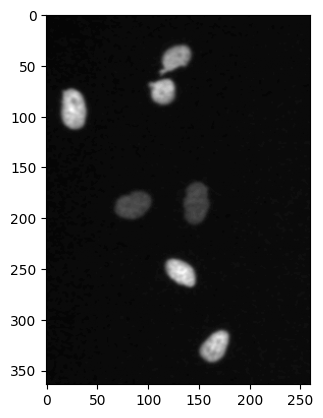

In [3]:
data_directory = '/Users/mhturner/Downloads'
filepath = os.path.join(data_directory, 'xy_8bit__mitocheck_incenp_t1.tif')

assert os.path.isfile(filepath)
img_cells = imread(filepath)
plt.imshow(img_cells, cmap='gray')


The overall goal here is to automatically detect cells, count them, and compute stats like the size and mean intensity

The first thing we want to do is create a **binary mask** for the image that identifies individual cells. To do this, let's try a **pseudocode** approach that allows us to not get lost in unfamiliar syntax. Pseudocoding has three steps:
1. Write (as comments) what you want to do and what the result should look like
2. Look up how to implement each command with: Google, StackExchange, LLMs*
3. Test your possible solution against your expectation from (1)


*https://microsoft365.com/copilot

### <span style='color:red;'>EXERCISE 1</span>: Finish the code for the remaining commands  (20 min)
For each of the remaining commands: look up how to implement the command, check to make sure it's doing what you want, and check your solution against your neighbors

If you are stuck, you can work with a neighbor to try to improve your search/prompt terms

#### Bonus: try other automatic thresholding methods in `skimage.filters` to see how they work for this data

https://scikit-image.org/docs/0.25.x/api/skimage.filters.html#


25.70354887623576


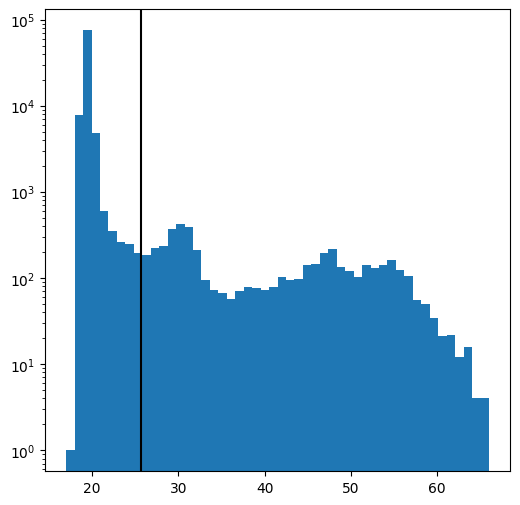

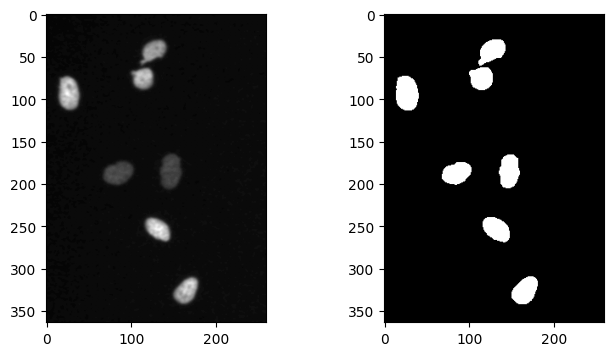

In [10]:
# Find a threshold intensity value to binarize the image
# a number. Values higher than this are included, lower are excluded
from skimage.filters import threshold_li, threshold_otsu
thresh = threshold_li(img_cells)
print(thresh)

# Look at the threshold compared to the distribution of pixel intensities
fh, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(img_cells.flatten(), bins=50)
ax.axvline(thresh, color='k')
ax.set_yscale('log')

# -----
# TODO: pick up here...
# Apply the threshold to return a binary mask
# Mask is the same size as the image, but all the values should be True/False (1 bit)
mask = img_cells > thresh

# View the mask alongside the original image
fh, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img_cells, cmap='gray')
ax[1].imshow(mask, cmap='gray')


Scikit image has tools to **label** and segmented components in the mask

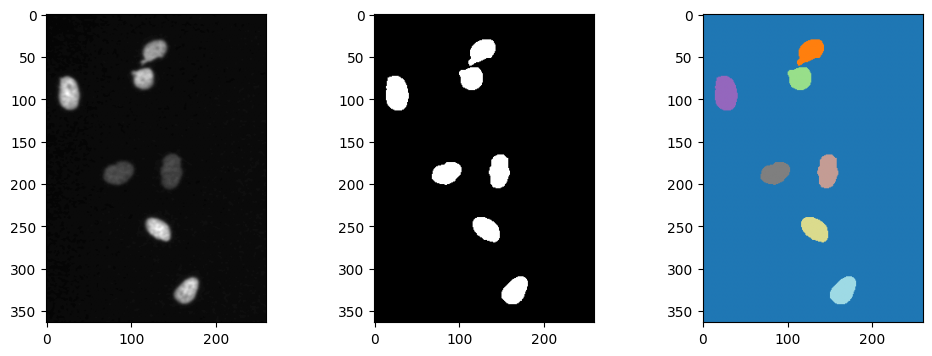

In [13]:
from skimage.measure import label

label_image = label(mask)

fh, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(img_cells, cmap='gray')
ax[1].imshow(mask, cmap='gray')
ax[2].imshow(label_image, cmap='tab20')

We can use the labels image to give us a mask for each cell. We're going to use each cell's mask to find the cell's area and mean intensity.

To go through each label we'll use a **for-loop**

In [15]:
list_of_items = ['apple', 1, 'cat', 10.85]
for item in list_of_items:
    print(item)

apple
1
cat
10.85


In [18]:
labels = np.unique(label_image)

for label in labels:
    cell_mask = label_image == label
    area = np.sum(cell_mask)
    intensity = np.mean(img_cells[cell_mask])
    print(label, area, intensity)

0 89558 19.029455771678688
1 660 40.39090909090909
2 607 43.44481054365733
3 914 46.26148796498906
4 768 29.2109375
5 702 29.93019943019943
6 696 47.372126436781606
7 735 44.69387755102041


In [19]:
labels = np.unique(label_image)[1:]

areas = []
intensities = []
for label in labels:
    cell_mask = label_image == label
    area = np.sum(cell_mask)
    intensity = np.mean(img_cells[cell_mask])
    areas.append(area)
    intensities.append(intensity)

num_cells = len(areas)
print(num_cells)
print(areas)
print(intensities)

7
[np.int64(660), np.int64(607), np.int64(914), np.int64(768), np.int64(702), np.int64(696), np.int64(735)]
[np.float64(40.39090909090909), np.float64(43.44481054365733), np.float64(46.26148796498906), np.float64(29.2109375), np.float64(29.93019943019943), np.float64(47.372126436781606), np.float64(44.69387755102041)]


### <span style='color:red;'>EXERCISE 2</span>: Write a cell quantification function  (20 min)
I'm giving you the skeleton of a function definition to take an image as an input and return lists of the mean intensity and area of each detected cell.

Take the relevant lines of code above and modify / arrange them into the body of the function to achieve what you want. Be sure to: check your variable names, only take the bits of code that you need to compute the intensity and area, and test your function afterwards

Hint: start with **pseduocode**


In [ ]:
from skimage.filters import threshold_li
from skimage.measure import label

def measure_cells(input_image):
    """ 
        measure_cells(input_image)
            Using automatic thresholding to identify and quantify cell properties from fluor images
        
        args
            input_image: 2 dimensional ndarray
        returns
            intensity - list
            area - list
    """
    # TODO: pick up here and write real code
    
    # compute the threshold

    # make a binary mask

    # identify the labels / components, exclude the background

    # Compute the number of cells (should be the number of labels)

    # Find the area of each label's mask

    # Compute the mean intensity of each cell's masked area


    return area, intensity

### Test your function

In [ ]:
img_cells = imread(filepath)
area, intensity = measure_cells(input_image=img_cells)

print(area, intensity)

### Using and modifying our function

OK so we have our function, which works well for the image we designed it on. What if we want to process new image files, including ones that may look a little different?

Let's load a more challenging image, which has objects of different sizes as well as cells that are touching and cells that are at the edges of the image...

Our function doesn't work so good for this image:

1. There are cells on the edges messing up our area calculations
2. There are some small bright objects that don't appear to be cells but are being labeled as cells
3. There are four touching cells that are counted as a single objects